In [3]:
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import tifffile as tfl
%matplotlib inline

In [4]:
data ='C:/Users/Toby/Desktop/landsat9 Composite/lc_classification/training data/Training_label_data.xls'
#comp ='C:/Users/Toby/Desktop/landsat9 Composite/clip_composite.tif'
comp ='C:/Users/Toby/Desktop/landsat9 Composite/pca.tif'

In [5]:
train_pts = pd.read_excel(data)
train_pts.head()

,FID,UTM_N,UTM_E,Label
0,0,1852580,189394,5
1,1,1857570,178471,5
2,2,1849760,180477,7
3,3,1853430,191777,5
4,4,1865200,185980,2


In [6]:
src= rasterio.open(comp)

In [7]:
# Magic code - this piece if code simply creates an exact copy of our input dataset and saves it in memory file. 
# There should be no reason to do this but this step increases the speed of the trainnig data extraction 
# from 2 hrs without it to 10 sec with creating the copy.
img = src.read()   # load our original input file bands to a numby array stack
#img = img/4096.0
#img = img.astype('float32')
profile = src.profile  # the copy the profile of the original GeoTIFF input file
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(**profile) as dst:
        for i in range(0, src.count):
            dst.write(img[i], i+1)
    dataset = memfile.open()
 
print(img.shape)    


(4, 960, 1511)


In [9]:
#bands = list(src.descriptions)
bands = ['PCA_1','PCA_2','PCA_3','PCA_4']
bands

['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']

In [10]:
train_pts.index = range(len(train_pts))
coords = [(x,y) for x, y in zip(train_pts.UTM_E, train_pts.UTM_N)]  # Create list of point coordinates

# Sample the each band of raster dataset at each point in the coordinate list
train_pts['Raster Value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column 
# Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now usef as column names
train_pts[bands] = pd.DataFrame(train_pts['Raster Value'].tolist(), index= train_pts.index)  
train_pts = train_pts.drop(['Raster Value'], axis=1)  # Remove Raster Value column
# Change the values for last three classes - original class numbers [0,1,2,3,4,7,8,15] -> [0,1,2,3,4,5,6,7]
#train_pts['GRID_CODE'] = train_pts['GRID_CODE'].replace([7,8,15],[5,6,7]) 
#train_pts.to_csv('train_pts.csv') # save our training dataset to CSV
train_pts.head() # visualize the first rows of the dataframe 

,FID,UTM_N,UTM_E,Label,PCA_1,PCA_2,PCA_3,PCA_4
0,0,1852580,189394,5,39849,13145,7954,31312
1,1,1857570,178471,5,25003,14931,7356,31413
2,2,1849760,180477,7,34197,11603,7478,32286
3,3,1853430,191777,5,40551,12899,8694,31295
4,4,1865200,185980,2,28459,7713,8505,32268


In [11]:
x = []
x.append(train_pts[bands].values)

y = train_pts['Label'].values

In [12]:
print(np.asarray(x).shape)

(1, 10000, 4)


In [13]:
print(y.shape)

(10000,)


In [14]:
from sklearn.ensemble import RandomForestClassifier
model_RF = []
rf = RandomForestClassifier(n_estimators=300, oob_score=True, max_features='auto')
rf = rf.fit(x[0],y)
model_RF.append(rf)

print('Our OOB prediction of accuracy of landsat 9 is {}'.format(model_RF[0].oob_score_*100))

Our OOB prediction of accuracy of landsat 9 is 78.57


In [15]:
from rasterio.plot import reshape_as_raster, reshape_as_image 
reshaped_img = reshape_as_image(img)
print('Landsat 9 Orignal image shape:',reshaped_img.shape)
reshaped_img = reshaped_img.reshape(-1,reshaped_img[2].shape[1])
print('Reshaped Image shape:',reshaped_img.shape)

Landsat 9 Orignal image shape: (960, 1511, 4)
Reshaped Image shape: (1450560, 4)


In [16]:
#Inferencing on image
pred = rf.predict(reshaped_img)
pred =pred.reshape(img.shape[1],img.shape[2])
print(pred.shape)

(960, 1511)


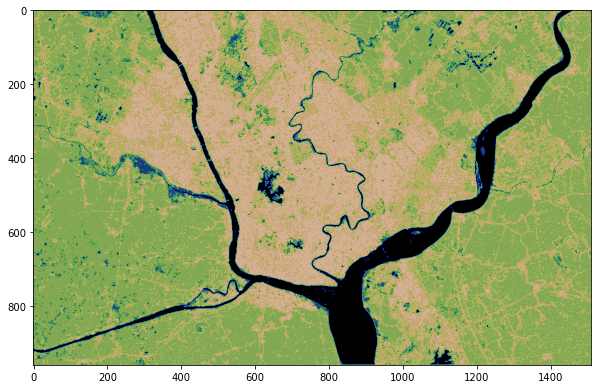

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(pred,cmap='gist_earth')

In [23]:
#reading mask label 
mask_label ='C:/Users/Toby/Desktop/landsat9 Composite/lc_classification/training data/mask_label.tif'
mask_label =tfl.imread(mask_label)
mask_label.shape

(961, 1512)

In [24]:
mask_label=mask_label[:-1,:-1]
mask_label[mask_label==15]=7

In [25]:
print(np.unique(y))
print(np.unique(pred))
print(np.unique(mask_label))

[1 2 3 4 5 6 7 8]
[1 2 3 4 5 6 7 8]
[1 2 3 4 5 6 7 8]


In [26]:
from sklearn.metrics import classification_report
label = ['Classification report']
pred_flat = pred.flatten()
label_flat = mask_label.flatten()
print(label)
print(classification_report(pred_flat,label_flat,zero_division=0));


['Classification report']
              precision    recall  f1-score   support

           1       0.80      0.89      0.84    111910
           2       0.34      0.42      0.37     23796
           3       0.01      0.25      0.01       346
           4       0.00      0.13      0.01        45
           5       0.85      0.78      0.81    790508
           6       0.03      0.28      0.05      3620
           7       0.77      0.76      0.77    520299
           8       0.01      0.25      0.02        36

    accuracy                           0.78   1450560
   macro avg       0.35      0.47      0.36   1450560
weighted avg       0.80      0.78      0.79   1450560



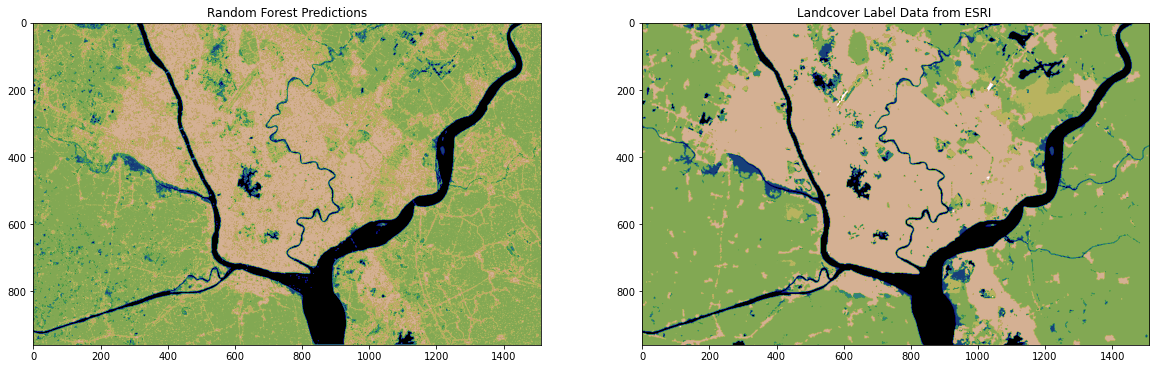

In [27]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(20,10))
ax1.imshow(pred,cmap='gist_earth')
ax1.set_title('Random Forest Predictions');
ax2.imshow(mask_label,cmap='gist_earth')
ax2.set_title('Landcover Label Data from ESRI ');
